In [13]:
# based on https://github.com/milindmalshe/Fully-Connected-Neural-Network-PyTorch/blob/master/FCN_MNIST_Classification_PyTorch.py
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools # to create the all possible combinations of hyperparameters
from tqdm import tqdm
from sklearn.manifold import TSNE
from collections import defaultdict

In [14]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Hyperparameters
input_size = 784
num_classes = 10
hidden_sizes = [500] 
num_epochs = [5] 
batch_sizes = [100]
learning_rates = [0.001]

default_batch_size = 100
validation_size = 10000 # number for validation

number_of_seeds = 1 # number of random seeds to generate

In [16]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
										   train=True,
										   transform=transforms.ToTensor(),
										   download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
										  train=False,
										  transform=transforms.ToTensor())

# Split dataset into training and validation sets
train_size = len(train_dataset) - validation_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, validation_size])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
										   batch_size=default_batch_size,
										   shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                        batch_size=default_batch_size,
                        shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
										  batch_size=default_batch_size,
										  shuffle=False)

In [17]:
def change_batch_size(loader, new_batch_size):
    loader.batch_sampler.batch_size = new_batch_size

def print_curr_combination(combination):
    seed_number = combination[0]
    hidden_size = combination[1]
    num_of_epochs = combination[2]
    learning_rate = combination[3]
    batch_size = combination[4]

    print(f"Seed number: #{seed_number}, hidden_size: {hidden_size}, # Epochs: {num_of_epochs}, learning_rate: {learning_rate}, batch_size: {batch_size}")

def generate_seed_numbers(number_of_seeds):
    return [random.randint(0, 100) for _ in range(number_of_seeds)]

def generate_combinations():
    seed_numbers = generate_seed_numbers(number_of_seeds)

    num_of_iterations = len(seed_numbers) * len(hidden_sizes) *len(num_epochs) *len(learning_rates) *len(batch_sizes)
    # Generate all possible combinations
    combinations      =  itertools.product(seed_numbers,hidden_sizes, num_epochs,learning_rates,batch_sizes)

    return combinations, num_of_iterations
    

In [18]:
# Fully connected neural network
class NeuralNet(nn.Module):
	def __init__(self, input_size, hidden_size, num_classes):
		super(NeuralNet, self).__init__()
		self.fc1 = nn.Linear(input_size, hidden_size) 
		self.relu = nn.ReLU()
		self.fc2 = nn.Linear(hidden_size, num_classes)  

	def forward(self, x):
		out = self.fc1(x)
		out = self.relu(out)
		hidden = out
		out = self.fc2(out)
		return out,hidden

In [19]:
criterion = nn.CrossEntropyLoss() # this is the loss function
combinations, num_of_iterations = generate_combinations()

In [20]:
def evaluate_model(model,data_loader):
    total_loss = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            images = images.reshape(-1, 28*28).to(device) # convert to vector
            labels = labels.to(device)
            outputs,_ = model(images)
            _, predicted = torch.max(outputs.data, 1) # takes max of last layer as prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            total_loss+=loss.item()
        
        data_errors = total_loss/len(data_loader) # get mean error
        
    return data_errors

In [21]:
def get_layer_output(model):
    # Extract hidden features for the entire training set
    hidden_features = []
    labels_list = []
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.reshape(-1, 28*28).to(device) # convert to vector
            labels = labels.to(device)
            _, hidden_output = model(images) # model returns (last layer output, first hidden layer output)
            hidden_features.append(hidden_output.cpu())
            labels_list.append(labels.cpu())

    return hidden_features, labels_list

In [22]:
def train_model(seed_number,hidden_size,num_epochs,learning_rate,batch_size):
	# set the seed
	torch.manual_seed(seed_number)
	# print("Using seed number: ",seed_number)

	change_batch_size(train_loader,batch_size)
	change_batch_size(test_loader,batch_size)
	change_batch_size(val_loader,batch_size)

	model = NeuralNet(input_size, hidden_size, num_classes).to(device)
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)# this is the algorithm used like gradient descent
		
	# train the model
	all_epochs_test_errors = []
	all_epochs_val_errors = []
	for epoch in range(num_epochs):
		# set model to train mode
		model.train()
		for i, (images, labels) in enumerate(train_loader):
			images = images.reshape(-1, input_size).to(device)
			labels = labels.to(device)

			outputs,_ = model(images)
			loss = criterion(outputs, labels)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

		# get e_te of each epoch
		test_errors = evaluate_model(model,test_loader)
		val_errors = evaluate_model(model,val_loader)
		
		print('Epoch [{}/{}], Seed [{}] Test Loss: {:.4f}'.format(epoch+1, num_epochs,seed_number, test_errors))

		all_epochs_test_errors.append(test_errors) # aggregate each epoch's error from this seed
		all_epochs_val_errors.append(val_errors)   # aggregate each epoch's error from this seed
	
	hidden_features,labels_list = get_layer_output(model) # after training done, get first layer output

	return model, all_epochs_test_errors,all_epochs_val_errors,hidden_features,labels_list


In [23]:
# main
training_tests_errors = []
training_val_errors = []
final_tests_errors    = []
for i,combination in tqdm(enumerate(combinations),total=num_of_iterations):
    curr_model, curr_test_errors,curr_val_errors ,hidden_features,labels_list = train_model(combination[0],combination[1],combination[2],combination[3],combination[4])
    training_tests_errors.append(curr_test_errors)
    training_val_errors.append(curr_val_errors)
    final_tests_errors.append(curr_test_errors[-1]) # get last valid test error from each seed

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/5], Seed [59] Test Loss: 0.1590
Epoch [2/5], Seed [59] Test Loss: 0.1080
Epoch [3/5], Seed [59] Test Loss: 0.0900
Epoch [4/5], Seed [59] Test Loss: 0.0824
Epoch [5/5], Seed [59] Test Loss: 0.0728


100%|██████████| 1/1 [00:42<00:00, 42.60s/it]


In [24]:
hidden_features = torch.cat(hidden_features).numpy()
labels_list = torch.cat(labels_list).numpy()

# Apply t-SNE to the hidden features
tsne = TSNE(n_components=2, random_state=42)
hidden_features_tsne = tsne.fit_transform(hidden_features)

# Collect all input images from the DataLoader
all_images = []
for images, _ in train_loader:
    all_images.append(images.view(-1, 28 * 28))

# Concatenate all images into a single array
input_images = torch.cat(all_images).numpy()

# Apply t-SNE to the entire dataset of input images
input_tsne = tsne.fit_transform(input_images)


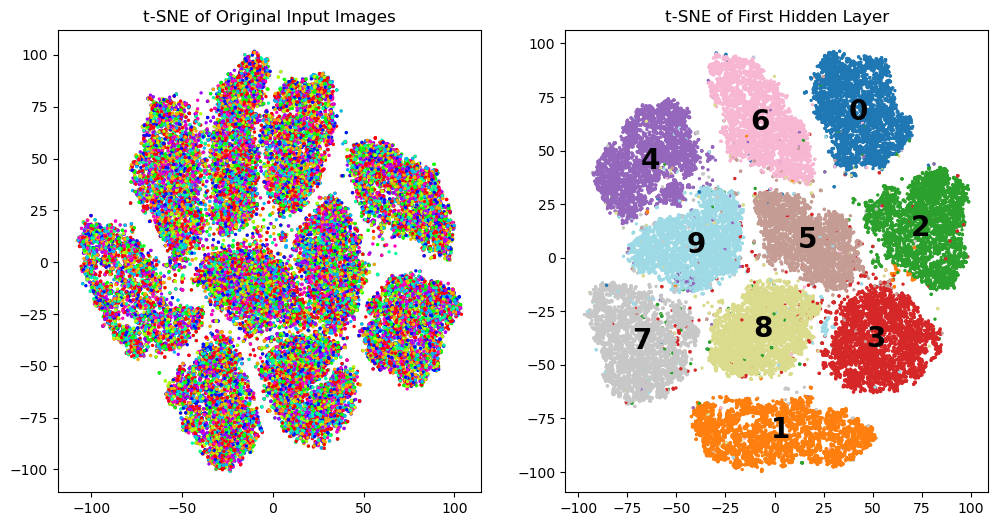

In [25]:
# Step 1: Compute centroids of each digit cluster in hidden_features_tsne
centroid_dict = defaultdict(list) # dict with keys of each class (digit) and value of arrays of all the tsne points from the first hidden layer
for i, label in enumerate(labels_list):
    centroid_dict[label].append(hidden_features_tsne[i])

centroids = {}
for label, points in centroid_dict.items():
    centroids[label] = np.mean(points, axis=0) # compute the mean of each centroid label such that we have the center for each cluster of points

# Plot t-SNE embedding of hidden features
plt.figure(figsize=(12, 6))

# Plot t-SNE embedding of original input images
plt.subplot(1, 2, 1)
scatter = plt.scatter(input_tsne[:, 0], input_tsne[:, 1], c=labels_list[:input_tsne.shape[0]], cmap='hsv', s=2)
plt.title('t-SNE of Original Input Images')

# the hidden features clustering
plt.subplot(1, 2, 2) 
scatter = plt.scatter(hidden_features_tsne[:, 0], hidden_features_tsne[:, 1], c=labels_list, cmap='tab20', s=2)
plt.title('t-SNE of First Hidden Layer')

# Annotate centroids with digit labels
for label, centroid in centroids.items():
    plt.text(centroid[0], centroid[1], str(int(label)), color='black', fontsize=20, ha='center', va='center', fontweight='bold')


plt.show()
